In [33]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load QM9 CSV
df = pd.read_csv("qm9_.csv")

# Subset the data for quick testing
subset_size = 20000  # You can change this to 1000, 10000, etc.       133883 size of full dataset
df = df.dropna(subset=["homo", "lumo", "gap", "alpha"]).sample(n=subset_size, random_state=42).reset_index(drop=True)

# Extract SMILES and targets
target_columns = ["homo", "lumo", "gap", "alpha"]
smiles_list = df["smiles"].tolist()
target_props = df[target_columns].values

# Normalize targets
scaler_forward = StandardScaler()
target_props = scaler_forward.fit_transform(target_props)

# Train/test split
train_smiles, test_smiles, train_y, test_y = train_test_split(smiles_list, target_props, test_size=0.2, random_state=42)



In [35]:
class SMILESTokenizerForward:
    def __init__(self):
        self.special = ['<pad>', '<bos>', '<eos>', '<unk>']
        self.vocab = {tok: idx for idx, tok in enumerate(self.special)}

    def tokenize(self, smiles):
        return list(smiles)

    def build_vocab(self, smiles_list):
        chars = set(c for smi in smiles_list for c in self.tokenize(smi))
        for c in sorted(chars):
            if c not in self.vocab:
                self.vocab[c] = len(self.vocab)

        self.inv_vocab = {v: k for k, v in self.vocab.items()}

    def encode(self, smiles, max_len=128):
        tokens = self.tokenize(smiles)
        ids = [self.vocab.get(tok, self.vocab['<unk>']) for tok in tokens]
        ids = [self.vocab['<bos>']] + ids[:max_len-2] + [self.vocab['<eos>']]
        ids += [self.vocab['<pad>']] * (max_len - len(ids))
        return torch.tensor(ids)

    def vocab_size(self):
        return len(self.vocab)

tokenizer_forward = SMILESTokenizerForward()
tokenizer_forward.build_vocab(train_smiles + test_smiles)

In [36]:
from torch.utils.data import Dataset, DataLoader
import torch

class QM9Dataset(Dataset):
    def __init__(self, smiles, targets, tokenizer):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        x = self.tokenizer.encode(self.smiles[idx])
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

train_dataset = QM9Dataset(train_smiles, train_y, tokenizer_forward)
test_dataset = QM9Dataset(test_smiles, test_y, tokenizer_forward)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [37]:
import torch.nn as nn

class TransformerRegressor(nn.Module):
    def __init__(self, vocab_size, seq_len, dim=256, heads=16, depth=6, ff_mult=2, n_outputs=4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 8)
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len, 8))
        self.proj = nn.Linear(8, dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=heads, dim_feedforward=ff_mult*dim, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.ReLU(),
            nn.Linear(dim // 2, n_outputs)
        )

    def forward(self, x):
        x = self.embed(x) + self.pos_embed[:, :x.size(1), :]
        x = self.proj(x)
        x = self.encoder(x)
        x = x.mean(dim=1)  # average pooling
        return self.head(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
forward_model = TransformerRegressor(tokenizer_forward.vocab_size(), seq_len=128).to(device)

In [ ]:
from tqdm import tqdm

optimizer = torch.optim.Adam(forward_model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

num_epochs = 5
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    forward_model.train()
    total_train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x, y = x.to(device), y.to(device)
        pred = forward_model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase
    forward_model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Epoch {epoch+1} [Test]"):
            x, y = x.to(device), y.to(device)
            pred = forward_model(x)
            loss = loss_fn(pred, y)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)


Epoch 3 [Test]: 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


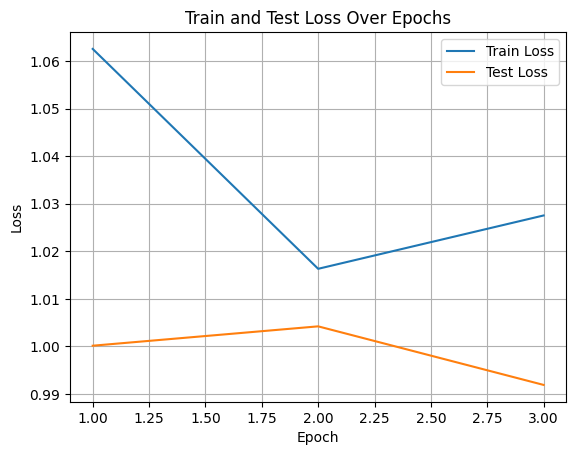

In [39]:
import matplotlib.pyplot as plt

# Plot losses
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

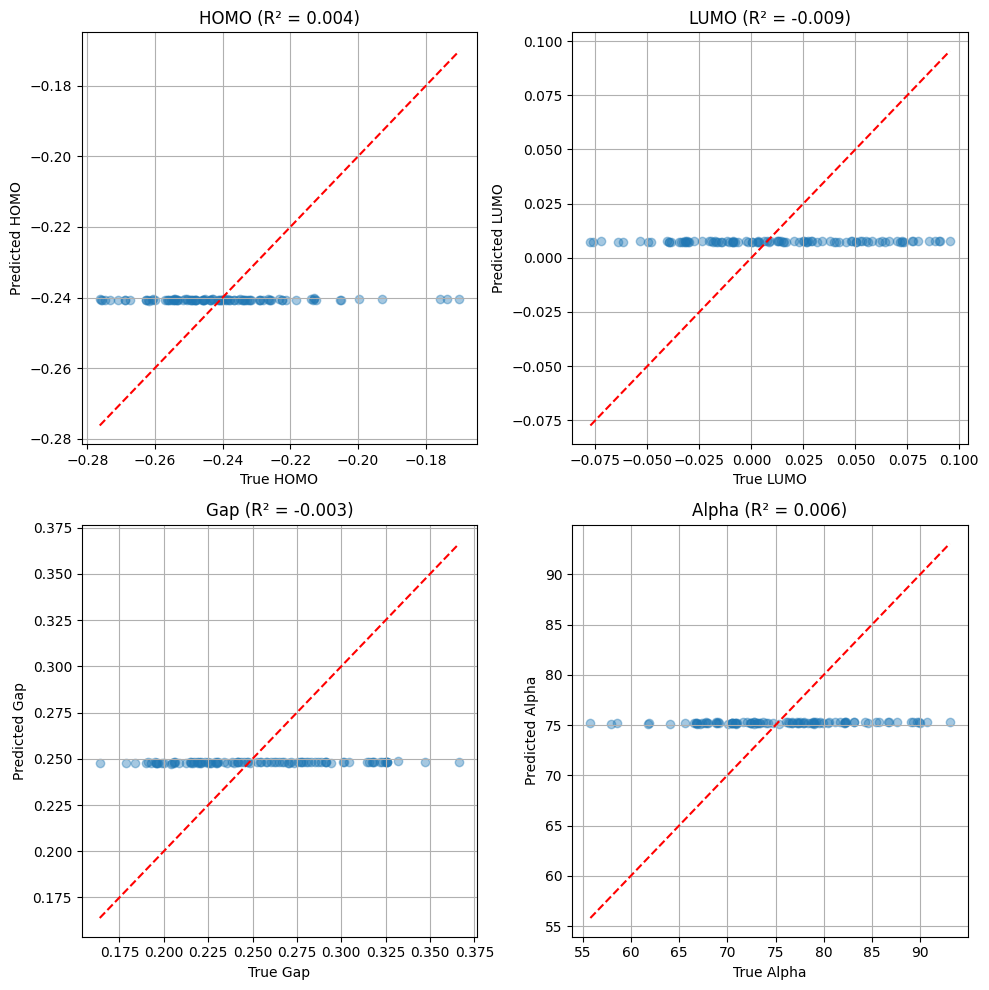

In [40]:
from sklearn.metrics import r2_score

forward_model.eval()
preds, truths = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = forward_model(x)
        preds.append(pred.cpu())
        truths.append(y)

preds = torch.cat(preds).numpy()
truths = torch.cat(truths).numpy()

# Inverse transform targets
preds = scaler_forward.inverse_transform(preds)
truths = scaler_forward.inverse_transform(truths)

# Plot setup
labels = ["HOMO", "LUMO", "Gap", "Alpha"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    r2 = r2_score(truths[:, i], preds[:, i])
    axs[i].scatter(truths[:, i], preds[:, i], alpha=0.4)
    axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                [truths[:, i].min(), truths[:, i].max()], 'r--')
    axs[i].set_xlabel(f"True {labels[i]}")
    axs[i].set_ylabel(f"Predicted {labels[i]}")
    axs[i].set_title(f"{labels[i]} (R² = {r2:.3f})")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

Autoregressive Transformer

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
RDKIT_AVAILABLE = True

In [ ]:
# --- Configuration ---
# Model Parameters (as specified by user)
D_MODEL = 256  # Channels
N_HEADS = 8
D_FF = 1024  # Feedforward Multiplier 4 -> 256 * 4 = 1024
SMILES_EMBEDDING_DIM = 16 # Embedding Dimension for SMILES tokens
# CROSS_ATTENTION_EMBEDDING_DIM = 8 # Not directly used as k/v dim for simplicity, see notes.
MAX_SEQ_LEN = 128  # Maximum SMILES sequence length
DECODER_DEPTH = 6  # Number of decoder layers
PROPERTY_DIM = 4  # homo, lumo, gap, alpha
DROPOUT = 0.1

# Training Parameters (example values)
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 3 # Placeholder: for generative model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Special Tokens
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>" # Start of Sequence
EOS_TOKEN = "<eos>" # End of Sequence
UNK_TOKEN = "<unk>" # Unknown token

In [43]:
# --- SMILES Tokenizer ---
class SMILESTokenizer:
    def __init__(self):
        self.special_tokens = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0

    def fit(self, smiles_list):
        # Gathers all unique characters from SMILES strings
        all_chars = set()
        for smiles in smiles_list:
            for char in smiles:
                all_chars.add(char)
        
        # Sort characters for consistent mapping
        sorted_chars = sorted(list(all_chars))
        
        # Initialize with special tokens
        self.char_to_idx = {token: i for i, token in enumerate(self.special_tokens)}
        current_idx = len(self.special_tokens)
        
        # Add unique SMILES characters
        for char in sorted_chars:
            if char not in self.char_to_idx: # Should not happen if special tokens are not in SMILES chars
                self.char_to_idx[char] = current_idx
                current_idx += 1
        
        self.idx_to_char = {i: char for char, i in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        
        # Ensure special tokens have correct indices
        self.pad_idx = self.char_to_idx[PAD_TOKEN]
        self.sos_idx = self.char_to_idx[SOS_TOKEN]
        self.eos_idx = self.char_to_idx[EOS_TOKEN]
        self.unk_idx = self.char_to_idx[UNK_TOKEN]

    def tokenize(self, smiles_string):
        # Converts a SMILES string to a list of token IDs
        return [self.char_to_idx.get(char, self.unk_idx) for char in smiles_string]

    def detokenize(self, token_ids):
        # Converts a list of token IDs back to a SMILES string
        chars = []
        for token_id in token_ids:
            if token_id == self.eos_idx:
                break
            if token_id not in [self.sos_idx, self.pad_idx]: # Don't include SOS or PAD in output string
                 chars.append(self.idx_to_char.get(token_id, UNK_TOKEN))
        return "".join(chars)


In [44]:

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=MAX_SEQ_LEN):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe) # Not a model parameter

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        # self.pe shape: (1, max_len, d_model)
        # We need to select the relevant part of pe: self.pe[:, :x.size(1), :]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


In [45]:
# --- Transformer Model ---
class SmilesTransformer(nn.Module):
    def __init__(self, vocab_size, property_dim, d_model, n_heads, d_ff,
                 decoder_depth, smiles_embedding_dim, max_seq_len, dropout, pad_idx): # Added pad_idx
        super(SmilesTransformer, self).__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.property_projector = nn.Linear(property_dim, d_model)
        self.smiles_embedder = nn.Embedding(vocab_size, smiles_embedding_dim, padding_idx=pad_idx) # Use passed pad_idx
        self.smiles_input_projector = nn.Linear(smiles_embedding_dim, d_model)
        self.positional_encoder = PositionalEncoding(d_model, dropout, max_seq_len)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, activation='relu', batch_first=True, norm_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=decoder_depth)
        self.output_layer = nn.Linear(d_model, vocab_size)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(DEVICE)

    def forward(self, properties, tgt_smiles_tokens, tgt_padding_mask=None):
        memory = self.property_projector(properties).unsqueeze(1) 
        tgt_embed = self.smiles_embedder(tgt_smiles_tokens)
        tgt_projected = self.smiles_input_projector(tgt_embed) * math.sqrt(self.d_model)
        tgt_pos_encoded = self.positional_encoder(tgt_projected)
        tgt_mask = self._generate_square_subsequent_mask(tgt_smiles_tokens.size(1))
        decoder_output = self.transformer_decoder(
            tgt=tgt_pos_encoded, memory=memory,
            tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask
        )
        return self.output_layer(decoder_output)

    def generate(self, properties, tokenizer, max_len=MAX_SEQ_LEN):
        self.eval()
        if properties.ndim == 1:
            properties = properties.unsqueeze(0)
        properties = properties.to(DEVICE)
        generated_ids = torch.tensor([[tokenizer.sos_idx]], dtype=torch.long, device=DEVICE)
        memory = self.property_projector(properties).unsqueeze(1)

        with torch.no_grad():
            for _ in range(max_len - 1):
                tgt_embed = self.smiles_embedder(generated_ids)
                tgt_projected = self.smiles_input_projector(tgt_embed) * math.sqrt(self.d_model)
                tgt_pos_encoded = self.positional_encoder(tgt_projected)
                tgt_mask = self._generate_square_subsequent_mask(generated_ids.size(1))
                decoder_output = self.transformer_decoder(tgt=tgt_pos_encoded, memory=memory, tgt_mask=tgt_mask)
                last_token_logits = self.output_layer(decoder_output[:, -1, :])
                predicted_id = torch.argmax(last_token_logits, dim=-1).unsqueeze(1)
                generated_ids = torch.cat([generated_ids, predicted_id], dim=1)
                if predicted_id.item() == tokenizer.eos_idx:
                    break
        return tokenizer.detokenize(generated_ids.squeeze(0).cpu().tolist())


In [46]:
# --- Wrapper for your TransformerRegressor (SMILES -> Property) ---
# Place this class definition in a new cell after your TransformerRegressor 
# and SMILESTokenizer class definitions.

class ForwardPropertyPredictorWrapper:
    def __init__(self, smiles_to_prop_model, tokenizer, scaler, property_names, device, max_seq_len_pred_model):
        """
        Wrapper for your TransformerRegressor to make it compatible.

        Args:
            smiles_to_prop_model: Your trained TransformerRegressor instance (from cell 5, trained in cell 7).
            tokenizer: Your SMILESTokenizer instance (from cell 3 or 12).
            scaler: StandardScaler instance fitted on the property_names.
            property_names (list): List of property names in the order the model predicts 
                                   and the scaler expects (e.g., ["homo", "lumo", "gap", "alpha"]).
            device: The torch device (e.g., torch.device("cpu")).
            max_seq_len_pred_model (int): The max sequence length your TransformerRegressor expects.
        """
        self.model = smiles_to_prop_model
        self.tokenizer = tokenizer
        self.scaler = scaler
        self.property_names = property_names
        self.device = device
        self.max_seq_len = max_seq_len_pred_model

    def predict_properties(self, smiles_string):
        """
        Predicts properties for a given SMILES string.

        Args:
            smiles_string (str): The SMILES string to predict properties for.

        Returns:
            dict: A dictionary of predicted (unscaled) properties.
        """
        self.model.eval() # Set the model to evaluation mode
        with torch.no_grad():
            # Tokenize the SMILES string using the 'encode' method from your SMILESTokenizer
            # This method should handle adding <bos>, <eos> and padding to max_seq_len.
            # (as per your cell 3 or cell 12 tokenizer and cell 4 QM9Dataset)
            token_ids = self.tokenizer.encode(smiles_string, max_len=self.max_seq_len)
            
            # Add batch dimension and move to device
            input_tensor = token_ids.unsqueeze(0).to(self.device) 

            # Get scaled predictions from your TransformerRegressor
            # Your model's forward pass (cell 5) takes x (tokenized SMILES)
            scaled_predictions_tensor = self.model(input_tensor) # Shape: (1, num_properties)
            
            # Inverse transform to get unscaled properties
            # The scaler expects a 2D array (n_samples, n_features)
            unscaled_predictions_np = self.scaler.inverse_transform(scaled_predictions_tensor.cpu().numpy())
            
            # Return as a dictionary with property names as keys
            return dict(zip(self.property_names, unscaled_predictions_np.squeeze()))

    def eval(self): # For consistency if the main function calls eval on it
        self.model.eval()

In [47]:
# --- Dataset and DataLoader ---
class QM9Dataset(Dataset):
    def __init__(self, properties_df, smiles_list, tokenizer, max_seq_len):
        self.properties = torch.tensor(properties_df.values, dtype=torch.float)
        self.smiles_list = smiles_list
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        props = self.properties[idx]
        smiles = self.smiles_list[idx]

        # Tokenize SMILES: <sos> + tokens + <eos>
        tokenized_smiles = [self.tokenizer.sos_idx] + self.tokenizer.tokenize(smiles) + [self.tokenizer.eos_idx]
        
        # Pad or truncate
        if len(tokenized_smiles) < self.max_seq_len:
            padding = [self.tokenizer.pad_idx] * (self.max_seq_len - len(tokenized_smiles))
            tokenized_smiles.extend(padding)
        else:
            tokenized_smiles = tokenized_smiles[:self.max_seq_len -1] + [self.tokenizer.eos_idx] # Ensure EOS if truncated

        # Input to decoder: <sos> t1 t2 ... tn-1 <pad> ...
        # Target for loss:   t1 t2 ... tn-1 <eos> <pad> ...
        # Both should have length max_seq_len
        
        # Decoder input sequence (starts with SOS, ends before final EOS if full, or with PADs)
        # Example: if tokenized_smiles = [sos, t1, t2, eos, pad, pad] (len 6, max_len 6)
        # input_seq = [sos, t1, t2, eos, pad] (remove last, for predicting next)
        # target_seq = [t1, t2, eos, pad, pad] (remove first)

        input_seq = torch.tensor(tokenized_smiles[:-1], dtype=torch.long)
        target_seq = torch.tensor(tokenized_smiles[1:], dtype=torch.long) # Shifted right

        # Create padding mask for the input sequence (True where it's a pad token)
        # This is for tgt_key_padding_mask in TransformerDecoder
        padding_mask = (input_seq == self.tokenizer.pad_idx)

        return props, input_seq, target_seq, padding_mask


In [48]:
# --- Generation and Evaluation ---
def generate_new_sequences(model, tokenizer, scaler, target_properties_unscaled_list, qm9_smiles_set, property_names):
    """
    Generates SMILES sequences for given target properties, checks against QM9,
    and visualizes them.
    Args:
        model: The trained SmilesTransformer model.
        tokenizer: The SMILESTokenizer.
        scaler: The fitted StandardScaler for properties.
        target_properties_unscaled_list (list of dicts): List of dictionaries, 
            each with unscaled property values (e.g., {'homo': -7.0, 'lumo': -1.0, 'gap': 6.0, 'alpha': 75.0}).
            Must contain 'gap' and 'alpha'. Other properties will be used if present, otherwise
            defaults might be needed or an error raised if not all 4 are present.
        qm9_smiles_set (set): A set of SMILES strings from the QM9 dataset for quick lookup.
        property_names (list): List of property names in the order expected by the scaler and model.
    Returns:
        list of dicts: Each dict contains 'target_properties_unscaled', 
                       'target_properties_scaled', 'generated_smiles', 
                       'is_in_qm9', 'is_valid_rdkit', 'mol_image_path'.
    """
    generated_results = []
    output_dir = "generated_molecules"
    os.makedirs(output_dir, exist_ok=True)

    for i, props_unscaled_dict in enumerate(target_properties_unscaled_list):
        print(f"\nGenerating for target (unscaled): {props_unscaled_dict}")

        # Ensure all required properties are present and in correct order for scaling
        current_props_unscaled = np.array([props_unscaled_dict.get(p_name, 0) for p_name in property_names])
        
        # Scale the properties
        props_scaled = scaler.transform(current_props_unscaled.reshape(1, -1))
        props_tensor = torch.tensor(props_scaled.squeeze(), dtype=torch.float).to(DEVICE)

        # Generate SMILES
        smiles_gen = model.generate(props_tensor, tokenizer, max_len=MAX_SEQ_LEN)
        
        is_in_qm9 = smiles_gen in qm9_smiles_set
        is_valid_rdkit = False
        mol_image_path = None

        if RDKIT_AVAILABLE and smiles_gen:
            mol = Chem.MolFromSmiles(smiles_gen)
            if mol:
                is_valid_rdkit = True
                try:
                    img = MolsToGridImage([mol], molsPerRow=1, subImgSize=(200,200))
                    mol_image_path = os.path.join(output_dir, f"generated_{i+1}.png")
                    # MolsToGridImage returns a PIL image. To save it:
                    # For this, you might need PIL (Pillow) if not already a dep of rdkit/matplotlib
                    # from PIL import Image (handled by MolsToGridImage if it creates an image object)
                    # For simplicity, let's assume MolsToGridImage can save or we use a simpler Draw.MolToImage
                    from rdkit.Chem.Draw import MolToFile
                    MolToFile(mol, mol_image_path, size=(300,300))
                    print(f"Visualized and saved to: {mol_image_path}")
                except Exception as e:
                    print(f"Error visualizing SMILES '{smiles_gen}': {e}")
                    mol_image_path = None # Reset on error
            else:
                print(f"Generated SMILES '{smiles_gen}' is not valid according to RDKit.")
        
        result = {
            'target_properties_unscaled': props_unscaled_dict,
            'target_properties_scaled': props_scaled.squeeze().tolist(),
            'generated_smiles': smiles_gen,
            'is_in_qm9': is_in_qm9,
            'is_valid_rdkit': is_valid_rdkit,
            'mol_image_path': mol_image_path
        }
        generated_results.append(result)

        print(f"Generated SMILES: {smiles_gen}")
        print(f"Is in QM9: {is_in_qm9}")
        print(f"RDKit valid: {is_valid_rdkit}")
        
    return generated_results

def plot_target_property_performance(generated_results, property_x='gap', property_y='alpha'):
    """
    Plots the target properties (e.g., gap vs alpha) for the generated sequences.
    Args:
        generated_results (list of dicts): Output from generate_new_sequences.
        property_x (str): Name of the property for the x-axis.
        property_y (str): Name of the property for the y-axis.
    """
    if not generated_results:
        print("No results to plot.")
        return

    x_values = [res['target_properties_unscaled'][property_x] for res in generated_results]
    y_values = [res['target_properties_unscaled'][property_y] for res in generated_results]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, c='blue', alpha=0.7, label='Target Properties for Generation')
    plt.xlabel(f"Target {property_x.capitalize()} (unscaled)")
    plt.ylabel(f"Target {property_y.capitalize()} (unscaled)")
    plt.title(f"Target Performance of Generated Molecules ({property_y.capitalize()} vs {property_x.capitalize()})")
    plt.legend()
    plt.grid(True)
    plot_filename = "target_properties_plot.png"
    plt.savefig(plot_filename)
    print(f"Target properties plot saved to {plot_filename}")
    # plt.show() # Uncomment if running in an environment that supports interactive plots

In [49]:
try:
    df_full = pd.read_csv("qm9_.csv")
    print(f"Successfully loaded qm9_.csv. Shape: {df_full.shape}")
except FileNotFoundError:
    print("Error: qm9_.csv not found. Please ensure the file is in the correct directory.")

# Drop rows with NaNs in specified property columns
property_cols = ["homo", "lumo", "gap", "alpha"]
df_full = df_full.dropna(subset=property_cols)
print(f"Shape after dropping NaNs: {df_full.shape}")

if df_full.empty:
    print("DataFrame is empty after dropping NaNs. Cannot proceed.")
    exit()

# Create a set of existing SMILES for quick lookup
qm9_smiles_set = set(df_full['smiles'].tolist())

Successfully loaded qm9_.csv. Shape: (133885, 13)
Shape after dropping NaNs: (133885, 13)


In [ ]:
# Filter for "high performing" molecules (e.g., top 25% in gap and alpha)
# You might want to adjust these quantiles
percentile = 0.8 # make 0.75 when ready to train
gap_threshold = df_full['gap'].quantile(percentile)
alpha_threshold = df_full['alpha'].quantile(percentile)

df_filtered = df_full[
    (df_full['gap'] >= gap_threshold) & \
    (df_full['alpha'] >= alpha_threshold)
].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Shape after filtering for high gap/alpha: {df_filtered.shape}")

if df_filtered.empty:
    print("DataFrame is empty after filtering for high gap/alpha. Try adjusting thresholds or check data.")
    exit()

Shape after filtering for high gap/alpha: (636, 13)


In [51]:
from torch.utils.data import random_split

# Normalize properties (already done)
scaler = StandardScaler()
df_filtered.loc[:, property_cols] = scaler.fit_transform(df_filtered[property_cols])

# Extract properties and SMILES
properties_data = df_filtered[property_cols]
smiles_data = df_filtered['smiles'].tolist()

# Initialize and fit tokenizer
tokenizer = SMILESTokenizer()
tokenizer.fit(smiles_data)
print(f"Tokenizer vocabulary size: {tokenizer.vocab_size}")
print(f"PAD index: {tokenizer.pad_idx}, SOS index: {tokenizer.sos_idx}, EOS index: {tokenizer.eos_idx}")

# Create dataset
qm9_dataset = QM9Dataset(properties_data, smiles_data, tokenizer, MAX_SEQ_LEN)

# 🔥 Split into training and test datasets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(qm9_dataset))
test_size = len(qm9_dataset) - train_size
train_dataset, test_dataset = random_split(qm9_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)



Tokenizer vocabulary size: 13
PAD index: 0, SOS index: 1, EOS index: 2


In [52]:
# 4. Initialize Model, Optimizer, Loss
model = SmilesTransformer(
    vocab_size=tokenizer.vocab_size,
    property_dim=PROPERTY_DIM,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    decoder_depth=DECODER_DEPTH,
    smiles_embedding_dim=SMILES_EMBEDDING_DIM,
    max_seq_len=MAX_SEQ_LEN,
    dropout=DROPOUT,
    pad_idx=tokenizer.pad_idx # Pass pad_idx explicitly
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Use CrossEntropyLoss, ignore padding index in loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_idx)

import matplotlib.pyplot as plt

# Store losses
train_losses = []
test_losses = []

# Define an evaluation function
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for props, input_seqs, target_seqs, padding_masks in data_loader:
            props = props.to(DEVICE)
            input_seqs = input_seqs.to(DEVICE)
            target_seqs = target_seqs.to(DEVICE)
            padding_masks = padding_masks.to(DEVICE)

            output_logits = model(props, input_seqs, tgt_padding_mask=padding_masks)
            loss = criterion(output_logits.reshape(-1, tokenizer.vocab_size), target_seqs.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(data_loader)

# Training loop
print(f"\n--- Starting Training Loop (for {NUM_EPOCHS} epochs) ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for batch_idx, (props, input_seqs, target_seqs, padding_masks) in enumerate(train_loader):  # <- make sure this is your train DataLoader
        props = props.to(DEVICE)
        input_seqs = input_seqs.to(DEVICE)
        target_seqs = target_seqs.to(DEVICE)
        padding_masks = padding_masks.to(DEVICE)

        optimizer.zero_grad()
        output_logits = model(props, input_seqs, tgt_padding_mask=padding_masks)
        loss = criterion(output_logits.reshape(-1, tokenizer.vocab_size), target_seqs.reshape(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 5 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set (replace `test_loader` with your actual DataLoader)
    avg_test_loss = evaluate(model, test_loader, criterion)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] completed. Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

print("--- Training Loop Finished ---")


--- Starting Training Loop (for 2 epochs) ---


/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [1/2], Batch [1/16], Loss: 13.5331
Epoch [1/2], Batch [6/16], Loss: 5.0278
Epoch [1/2], Batch [11/16], Loss: 3.1578
Epoch [1/2], Batch [16/16], Loss: 2.2652
Epoch [1/2] completed. Train Loss: 5.1261, Test Loss: 1.9337
Epoch [2/2], Batch [1/16], Loss: 2.5183
Epoch [2/2], Batch [6/16], Loss: 2.0453
Epoch [2/2], Batch [11/16], Loss: 2.1580
Epoch [2/2], Batch [16/16], Loss: 1.8689
Epoch [2/2] completed. Train Loss: 2.1596, Test Loss: 1.3534
--- Training Loop Finished ---


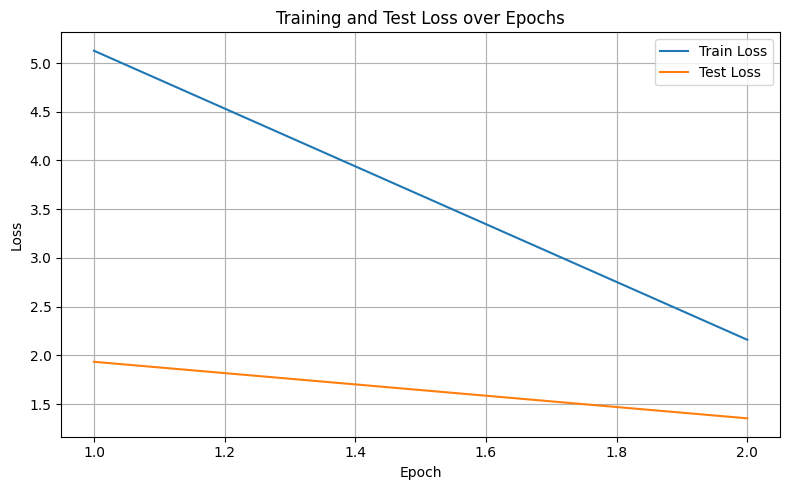

In [53]:
# Plotting
plt.figure(figsize=(8,5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def compare_on_random_samples(model, tokenizer, scaler, full_dataset_df, 
                              property_column_names, num_samples=5):
    """
    Randomly samples from the full dataset, generates SMILES using the model,
    compares them to the original SMILES, and visualizes valid pairs,
    excluding pairs where either SMILES sequence is longer than 32 tokens.

    Args:
        model: The trained SmilesTransformer model.
        tokenizer: The SMILESTokenizer.
        scaler: The fitted StandardScaler for properties.
        full_dataset_df (pd.DataFrame): The complete qm9 dataframe (unscaled, unfiltered).
        property_column_names (list): List of property names in order for the scaler.
        num_samples (int): Number of random samples to evaluate.
    """
    print(f"\n--- Comparing Model Predictions on {num_samples} Random Samples from QM9 ---")
    
    if full_dataset_df.empty:
        print("Full dataset is empty, cannot sample.")
        return

    if num_samples > len(full_dataset_df):
        print(f"Requested {num_samples} samples, but dataset only has {len(full_dataset_df)}. Adjusting.")
        num_samples = len(full_dataset_df)

    required_cols_for_sampling = ['smiles'] + property_column_names
    # Ensure pandas (pd) is available, typically imported in the main script as 'pd'
    # Drop rows where any of these essential columns are NaN before sampling
    sample_df = full_dataset_df.dropna(subset=required_cols_for_sampling).sample(n=num_samples, random_state=42) # for reproducibility

    if sample_df.empty:
        print("No valid samples found after attempting to drop NaNs from required columns. Cannot proceed.")
        return

    valid_rdkit_pairs = [] # To store dicts of valid original/generated pairs

    for index, row in sample_df.iterrows():
        original_smiles = row['smiles']
        # Prepare properties as a DataFrame for the scaler to avoid UserWarning
        unscaled_props_numpy = row[property_column_names].values.astype(float).reshape(1, -1)
        unscaled_props_df = pd.DataFrame(unscaled_props_numpy, columns=property_column_names)
        
        try:
            # Scaler transform expects a DataFrame if fitted with one, or matching columns.
            # It returns a NumPy array.
            scaled_props_numpy = scaler.transform(unscaled_props_df) # Corrected: remove .values
        except Exception as e:
            print(f"Error scaling properties for sample {index} (SMILES: {original_smiles}): {e}")
            print(f"Unscaled properties: {unscaled_props_numpy}")
            continue

        # Ensure scaled_props_numpy is correctly shaped for torch.tensor
        # .squeeze() removes single-dimensional entries from the shape of an array.
        # scaler.transform returns a 2D array (e.g., (1, num_features)), squeeze makes it 1D.
        squeezed_props = scaled_props_numpy.squeeze()
        
        # Ensure the tensor is correctly formed.
        # If only one property, squeeze might make it 0-dim.
        if squeezed_props.ndim == 0: 
            scaled_props_tensor = torch.tensor([squeezed_props.item()], dtype=torch.float).to(DEVICE)
        elif squeezed_props.ndim == 1:
             scaled_props_tensor = torch.tensor(squeezed_props, dtype=torch.float).to(DEVICE)
        else: 
            # This case should ideally not be hit if squeeze works as expected on (1, N) input
            print(f"Warning: Unexpected shape for scaled_props_numpy after squeeze: {squeezed_props.shape}. Using as is.")
            scaled_props_tensor = torch.tensor(squeezed_props, dtype=torch.float).to(DEVICE)

        generated_smiles = model.generate(scaled_props_tensor, tokenizer, max_len=MAX_SEQ_LEN)
        
        print(f"\nSample {index}:")
        print(f"  Original Properties (Unscaled):")
        for i, p_name in enumerate(property_column_names):
            print(f"    {p_name}: {unscaled_props_numpy[0, i]:.4f}") # Use unscaled_props_numpy for printing
        print(f"  Original SMILES: {original_smiles}")
        print(f"  Generated SMILES: {generated_smiles}")

        original_mol_valid = False
        generated_mol_valid = False
        original_mol_rdkit = None
        generated_mol_rdkit = None

        if RDKIT_AVAILABLE: # Global flag indicating RDKit was imported
            if original_smiles:
                original_mol_rdkit = Chem.MolFromSmiles(original_smiles) # Chem from rdkit
                if original_mol_rdkit:
                    original_mol_valid = True
            
            if generated_smiles:
                generated_mol_rdkit = Chem.MolFromSmiles(generated_smiles)
                if generated_mol_rdkit:
                    generated_mol_valid = True
                    print(f"  Generated SMILES is RDKit Valid: Yes")
                    if original_mol_valid: # Only store if original is also valid for comparison
                         valid_rdkit_pairs.append({
                             "original_smiles": original_smiles,
                             "generated_smiles": generated_smiles,
                             "original_mol": original_mol_rdkit,
                             "generated_mol": generated_mol_rdkit,
                             "id": index
                         })
                else:
                    print(f"  Generated SMILES is RDKit Valid: No (RDKit could not parse)")
            elif not generated_smiles:
                print(f"  Generated SMILES is Empty.")
        else:
            print("  RDKIT not available. Skipping SMILES validation and graphical output.")

    # After the loop, print all valid (original, generated) SMILES pairs
    if RDKIT_AVAILABLE and valid_rdkit_pairs:
        print("\n\n--- Valid RDKit-Generated SMILES Pairs (Original vs. Generated) ---")
        # This loop remains to print all valid pairs regardless of length for textual output
        for pair_info in valid_rdkit_pairs:
            print(f"Sample ID: {pair_info['id']}")
            print(f"  Original:  {pair_info['original_smiles']}")
            print(f"  Generated: {pair_info['generated_smiles']}")

        print("\n\n--- Graphical Comparison of Valid Original vs. Generated Sequences (<= 32 tokens) ---")
        
        mols_to_draw = []
        legends = []
        max_token_len_for_display = 64

        for pair_info in valid_rdkit_pairs:
            # Tokenize original and generated SMILES to check their length
            # The tokenizer.tokenize() method returns a list of token IDs.
            # We add SOS and EOS tokens for a more accurate length, similar to training.
            # However, for simple length check, just tokenizing the string itself is usually sufficient.
            # Let's use the raw tokenized length of the SMILES string itself.
            original_tokens = tokenizer.tokenize(pair_info['original_smiles'])
            generated_tokens = tokenizer.tokenize(pair_info['generated_smiles'])

            if len(original_tokens) <= max_token_len_for_display and \
               len(generated_tokens) <= max_token_len_for_display:
                mols_to_draw.append(pair_info['original_mol'])
                legends.append(f"Sample {pair_info['id']}\nOriginal ({len(original_tokens)} tok)")
                mols_to_draw.append(pair_info['generated_mol'])
                legends.append(f"Sample {pair_info['id']}\nGenerated ({len(generated_tokens)} tok)")
            else:
                print(f"Skipping Sample ID {pair_info['id']} from graphical display due to token length:")
                print(f"  Original SMILES: {pair_info['original_smiles']} (Tokens: {len(original_tokens)})")
                print(f"  Generated SMILES: {pair_info['generated_smiles']} (Tokens: {len(generated_tokens)})")


        if mols_to_draw:
            mols_per_row = 2 
            # MolsToGridImage from rdkit.Chem.Draw
            img = MolsToGridImage(mols_to_draw, molsPerRow=mols_per_row, subImgSize=(300,300), legends=legends)
            
            output_comparison_dir = "comparison_visualizations"
            os.makedirs(output_comparison_dir, exist_ok=True) # os from import os
            comparison_image_path = os.path.join(output_comparison_dir, "original_vs_generated_comparison_len_filtered.png") # New filename
            
            try:
                # Try standard PIL save first
                img.save(comparison_image_path)
                print(f"Graphical comparison (length filtered) saved to: {comparison_image_path}")
            except AttributeError: 
                # If .save attribute is missing, it might be an IPython Image or similar
                if hasattr(img, 'data') and isinstance(img.data, bytes):
                    print(f"Standard img.save() failed. Attempting to save image via .data attribute.")
                    try:
                        with open(comparison_image_path, 'wb') as f_img_data:
                            f_img_data.write(img.data)
                        print(f"Graphical comparison (length filtered) saved via .data to: {comparison_image_path}")
                    except Exception as e_data_write:
                        print(f"Error writing img.data to file: {e_data_write}")
                else:
                    print(f"Error: img.save() failed and img.data attribute is not available/bytes.")
                    print(f"Type of img object: {type(img)}. Cannot save image.")
            except Exception as e_general_save: # Catch other potential errors during save
                print(f"An unexpected error occurred while saving the image: {e_general_save}")
                print(f"Type of img object: {type(img)}")
        else:
            print("No RDKit-valid pairs (meeting token length criteria) to display graphically.")
            
    elif not RDKIT_AVAILABLE:
        print("\nSkipping graphical output as RDKit is not available.")
    elif not valid_rdkit_pairs: # RDKit available, but no valid pairs found
        print("\nRDKit is available, but no RDKit-valid generated SMILES (paired with valid originals) to display graphically.")



compare_on_random_samples(model, tokenizer, scaler, df_full, property_cols, num_samples=20)


--- Comparing Model Predictions on 5 Random Samples from QM9 ---

Sample 3115:
  Original Properties (Unscaled):
    homo: -0.2627
    lumo: -0.0086
    gap: 0.2541
    alpha: 55.8100
  Original SMILES: N#CC12CC1CO2
  Generated SMILES: C222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222
  Generated SMILES is RDKit Valid: No (RDKit could not parse)


[17:42:12] SMILES Parse Error: duplicated ring closure 2 bonds atom 0 to itself for input: 'C222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222'



Sample 117879:
  Original Properties (Unscaled):
    homo: -0.2697
    lumo: -0.0657
    gap: 0.2040
    alpha: 77.3400
  Original SMILES: COCC(O)C#CC=O
  Generated SMILES: NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
  Generated SMILES is RDKit Valid: Yes

Sample 23433:
  Original Properties (Unscaled):
    homo: -0.2258
    lumo: 0.0156
    gap: 0.2414
    alpha: 76.7500
  Original SMILES: COC1C2CC(=NO)C12
  Generated SMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
  Generated SMILES is RDKit Valid: Yes

Sample 61955:
  Original Properties (Unscaled):
    homo: -0.2438
    lumo: -0.0199
    gap: 0.2239
    alpha: 79.5000
  Original SMILES: CC(CC=O)OCC#C
  Generated SMILES: C(C(C(COC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(COCOCOCOC(COCOC(C(C(C(C(C(C(C(C(C(C(C(COCOC(C(COCOCOCOCOCOCOC(C(C
  Generated SMIL

[17:42:15] SMILES Parse Error: extra open parentheses while parsing: C(C(C(COC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(COCOCOCOC(COCOC(C(C(C(C(C(C(C(C(C(C(C(COCOC(C(COCOCOCOCOCOCOC(C(C
[17:42:15] SMILES Parse Error: check for mistakes around position 2:
[17:42:15] C(C(C(COC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
[17:42:15] ~^
[17:42:15] SMILES Parse Error: extra open parentheses while parsing: C(C(C(COC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(COCOCOCOC(COCOC(C(C(C(C(C(C(C(C(C(C(C(COCOC(C(COCOCOCOCOCOCOC(C(C
[17:42:15] SMILES Parse Error: check for mistakes around position 4:
[17:42:15] C(C(C(COC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
[17:42:15] ~~~^
[17:42:15] SMILES Parse Error: extra open parentheses while parsing: C(C(C(COC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(COCOCOCOC(COCOC(C(C(C(C(C(C(C(C(C(C(C(COCOC(C(COCOCOCOCOCOCOC(C(C
[17:42:15] SMILES Parse Error: check for mistakes around position 6:
[17:42:15] C(C(C(COC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
[17:42:15] ~~


Sample 98811:
  Original Properties (Unscaled):
    homo: -0.2343
    lumo: 0.0056
    gap: 0.2400
    alpha: 77.8100
  Original SMILES: COC(=N)N1CCC1=N
  Generated SMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(C(CCCCCOCOCOCOCCCOCOCOC(CCCC(C(COCOC(COCOC(C(COCOCOCOCOCOCOCOCOCOCOCOCOC
  Generated SMILES is RDKit Valid: No (RDKit could not parse)


--- Valid RDKit-Generated SMILES Pairs (Original vs. Generated) ---
Sample ID: 117879
  Original:  COCC(O)C#CC=O
  Generated: NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Sample ID: 23433
  Original:  COC1C2CC(=NO)C12
  Generated: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


--- Graphical Comparison of Valid Original vs. Generated Sequences (<= 32 tokens) ---
Skipping Sample ID 117879 from graphical display due to token length:
  Original SMILES: COCC(O)C#CC=O (

[17:42:16] SMILES Parse Error: extra open parentheses while parsing: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(C(CCCCCOCOCOCOCCCOCOCOC(CCCC(C(COCOC(COCOC(C(COCOCOCOCOCOCOCOCOCOCOCOCOC
[17:42:16] SMILES Parse Error: check for mistakes around position 55:
[17:42:16] CCCCCCCCCCCCCCCCCCCC(C(CCCCCOCOCOCOCCCOCO
[17:42:16] ~~~~~~~~~~~~~~~~~~~~^
[17:42:16] SMILES Parse Error: extra open parentheses while parsing: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(C(CCCCCOCOCOCOCCCOCOCOC(CCCC(C(COCOC(COCOC(C(COCOCOCOCOCOCOCOCOCOCOCOCOC
[17:42:16] SMILES Parse Error: check for mistakes around position 57:
[17:42:16] CCCCCCCCCCCCCCCCCC(C(CCCCCOCOCOCOCCCOCOCO
[17:42:16] ~~~~~~~~~~~~~~~~~~~~^
[17:42:16] SMILES Parse Error: extra open parentheses while parsing: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(C(CCCCCOCOCOCOCCCOCOCOC(CCCC(C(COCOC(COCOC(C(COCOCOCOCOCOCOCOCOCOCOCOCOC
[17:42:16] SMILES Parse Error: check for mistakes around position 79:
[17:42:16] CCCCOCOCOCOCCCOC


Generating for target (unscaled): {'homo': -1.7206811159122943, 'lumo': 2.8518436879588784, 'gap': 4.572524803871173, 'alpha': np.float64(129.4206659084373)}


/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[17:42:17] SMILES Parse Error: syntax error while parsing: 2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222
[17:42:17] SMILES Parse Error: check for mistakes around position 1:
[17:42:17] 22222222222222222222222222222222222222222
[17:42:17] ^
[17:42:17] SMILES Parse Error: Failed parsing SMILES '2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222' for input: '2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packa

Generated SMILES '2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222' is not valid according to RDKit.
Generated SMILES: 2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': -1.5212212735702488, 'lumo': 2.08255237833984, 'gap': 3.603773651910089, 'alpha': np.float64(142.83211998766987)}


[17:42:18] SMILES Parse Error: syntax error while parsing: 2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222
[17:42:18] SMILES Parse Error: check for mistakes around position 1:
[17:42:18] 22222222222222222222222222222222222222222
[17:42:18] ^
[17:42:18] SMILES Parse Error: Failed parsing SMILES '2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222' for input: '2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222' is not valid according to RDKit.
Generated SMILES: 2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.1363594147228363), 'lumo': np.float64(0.053009574413983074), 'gap': np.float64(0.18936898913681938), 'alpha': np.float64(187.21586302211372)}


[17:42:19] SMILES Parse Error: syntax error while parsing: (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[17:42:19] SMILES Parse Error: check for mistakes around position 1:
[17:42:19] (((((((((((((((((((((((((((((((((((((((((
[17:42:19] ^
[17:42:19] SMILES Parse Error: Failed parsing SMILES '(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: '((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES '(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.3718850259148677), 'lumo': np.float64(0.13481071529718786), 'gap': np.float64(0.5066957412120556), 'alpha': np.float64(99.79816401073508)}


[17:42:20] SMILES Parse Error: ring closure 2 duplicates bond between atom 17 and atom 18 for input: 'CCCCCCCCCCCCCCCCCC2C2CCCCCCCCCC2CCCCCCCCCCCCCCCCCCCCCCC2C2C2CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC'
/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Generated SMILES 'CCCCCCCCCCCCCCCCCC2C2CCCCCCCCCC2CCCCCCCCCCCCCCCCCCCCCCC2C2C2CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' is not valid according to RDKit.
Generated SMILES: CCCCCCCCCCCCCCCCCC2C2CCCCCCCCCC2CCCCCCCCCCCCCCCCCCCCCCC2C2C2CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
Is in QM9: False
RDKit valid: False

Generating for target (unscaled): {'homo': np.float64(-0.31961460758531296), 'lumo': np.float64(-0.05180617236480892), 'gap': np.float64(0.267808435220504), 'alpha': np.float64(193.31376049616532)}
Generated SMILES '(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' is not valid according to RDKit.
Generated SMILES: (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
Is in QM9: False
RDKit valid: False


[17:42:21] SMILES Parse Error: syntax error while parsing: (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
[17:42:21] SMILES Parse Error: check for mistakes around position 1:
[17:42:21] (((((((((((((((((((((((((((((((((((((((((
[17:42:21] ^
[17:42:21] SMILES Parse Error: Failed parsing SMILES '(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((' for input: '((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((('


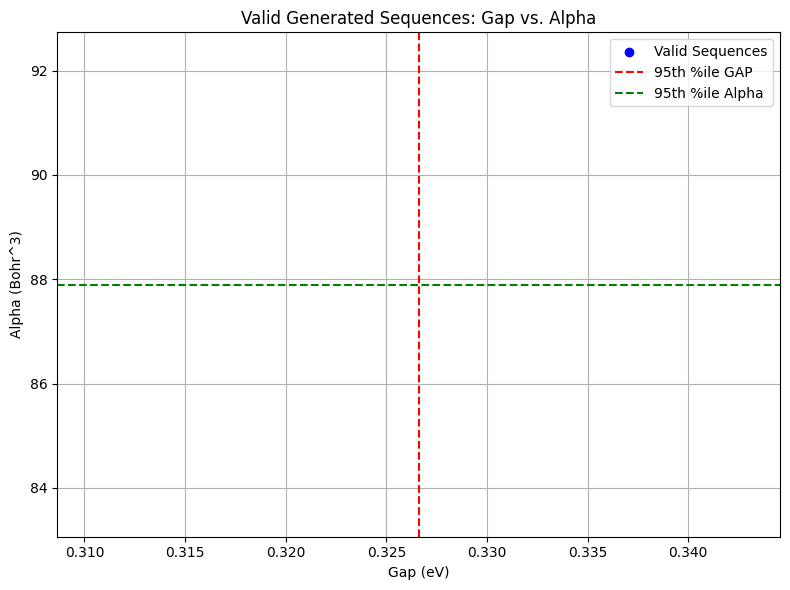

In [ ]:
import random

# Number of sequences to generate
x = 100

# Get statistics from full dataset for generating random properties
homo_range = (df_full['homo'].min(), df_full['homo'].max())
lumo_range = (df_full['lumo'].min(), df_full['lumo'].max())
alpha_range = (df_full['alpha'].min(), df_full['alpha'].max())

# High-performing cutoffs (you already calculated these)
high_gap_target = df_full['gap'].quantile(0.95)
high_alpha_target = df_full['alpha'].quantile(0.95)

# 1. Generate random property sets
target_properties_list_unscaled = []

for _ in range(x):
    # 20% chance to sample from high-performing region
    if random.random() < 0.2:
        homo = random.uniform(-3.0, -1.5)
        lumo = random.uniform(2.0, 3.0)
        alpha = random.uniform(high_alpha_target, alpha_range[1])
    else:
        homo = random.uniform(*homo_range)
        lumo = random.uniform(*lumo_range)
        alpha = random.uniform(*alpha_range)

    # Ensure physical plausibility: LUMO > HOMO
    if lumo <= homo:
        lumo = homo + abs(np.random.normal(2.5, 0.5))  # Add positive gap

    gap = lumo - homo
    target_properties_list_unscaled.append({
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'alpha': alpha
    })

# 2. Generate new sequences using the existing pipeline
generated_smiles_info = generate_new_sequences(
    model, 
    tokenizer, 
    scaler,
    target_properties_list_unscaled,
    qm9_smiles_set,
    property_cols
)

# 3. Filter valid sequences
valid_sequences = [
    info for info in generated_smiles_info 
    if info.get('valid', False)
]

# 4. Plot GAP vs. Alpha for valid sequences
gaps = [entry['target_properties']['gap'] for entry in valid_sequences]
alphas = [entry['target_properties']['alpha'] for entry in valid_sequences]

plt.figure(figsize=(8, 6))
plt.scatter(gaps, alphas, color='blue', label='Valid Sequences')

# Vertical lines for maximum values
plt.axvline(x=high_gap_target, color='red', linestyle='--', label='95th %ile GAP')
plt.axhline(y=high_alpha_target, color='green', linestyle='--', label='95th %ile Alpha')

plt.xlabel('Gap (eV)')
plt.ylabel('Alpha (Bohr^3)')
plt.title('Valid Generated Sequences: Gap vs. Alpha')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('target_properties_plot.png')
plt.show()


In [ ]:
from rdkit.Chem.Draw import MolsToGridImage, MolToFile

def generate_evaluate_plot_high_performers_v2(
    prop_to_smiles_model: nn.Module,         # Autoregressive SmilesTransformer (Property -> SMILES)
    prop_to_smiles_tokenizer,                # Tokenizer for prop_to_smiles_model
    prop_to_smiles_scaler: StandardScaler,   # Scaler for properties fed into prop_to_smiles_model
    
    smiles_to_prop_model: nn.Module,         # Forward TransformerRegressor (SMILES -> Property)
    smiles_to_prop_tokenizer,                # Tokenizer for smiles_to_prop_model
    smiles_to_prop_scaler: StandardScaler,   # Scaler for properties predicted by smiles_to_prop_model
    
    qm9_full_df: pd.DataFrame,               # Full QM9 dataset (unscaled, unfiltered)
    property_names: list,                    # e.g., ['homo', 'lumo', 'gap', 'alpha']
    device: torch.device,
    
    max_seq_len_gen: int = 128,              # Max sequence length for generation
    max_seq_len_eval: int = 128,             # Max sequence length for forward evaluation model
    
    num_generations: int = 100,              # Number of SMILES generation attempts
    gap_threshold_percentile: float = 0.90,
    alpha_threshold_percentile: float = 0.90,
    generation_target_multiplier: float = 1.05, # Target 5% above percentile
    
    csv_filename: str = "generated_high_performers_v2.csv",
    plot_dir: str = "generation_plots_v2",
    num_best_to_visualize: int = 10
):
    """
    Generates new SMILES aiming for high performance, evaluates them, stores, and plots.
    """
    print(f"\n--- Generating and Evaluating High-Performing SMILES (v2) ---")
    print(f"Targeting high values for: gap, alpha")
    print(f"Attempting {num_generations} generations.")

    if qm9_full_df.empty:
        print("Full QM9 dataset is empty. Aborting.")
        return None

    # 1. Determine Performance Baselines from the full QM9 dataset
    baseline_gap_thresh = qm9_full_df['gap'].quantile(gap_threshold_percentile)
    baseline_alpha_thresh = qm9_full_df['alpha'].quantile(alpha_threshold_percentile)
    print(f"Baseline QM9 Gap Threshold ({gap_threshold_percentile*100:.0f}th percentile): {baseline_gap_thresh:.4f}")
    print(f"Baseline QM9 Alpha Threshold ({alpha_threshold_percentile*100:.0f}th percentile): {baseline_alpha_thresh:.4f}")

    dataset_means = {prop: qm9_full_df[prop].mean() for prop in property_names}

    # 2. Set Generation Target Properties (Unscaled)
    target_props_unscaled_dict = {}
    target_props_unscaled_dict['gap'] = baseline_gap_thresh * generation_target_multiplier
    target_props_unscaled_dict['alpha'] = baseline_alpha_thresh * generation_target_multiplier
    
    # For HOMO and LUMO, we need to be careful. Let's use means for now, or derive them.
    # If gap = lumo - homo, and we have target gap, and mean homo/lumo
    # Let's keep homo at mean and adjust lumo based on target gap.
    target_props_unscaled_dict['homo'] = dataset_means.get('homo', -0.25) # fallback if not in means
    target_props_unscaled_dict['lumo'] = target_props_unscaled_dict['homo'] + target_props_unscaled_dict['gap']
    
    # Ensure all properties are present for scaling
    for prop in property_names:
        if prop not in target_props_unscaled_dict:
            target_props_unscaled_dict[prop] = dataset_means.get(prop, 0.0)


    print("\nTarget Properties for Generation (Unscaled):")
    for prop, val in target_props_unscaled_dict.items():
        print(f"  {prop}: {val:.4f}")

    # 3. Scale Generation Target Properties (for prop_to_smiles_model)
    # The prop_to_smiles_scaler expects input in the order of property_names
    target_props_unscaled_array = np.array([target_props_unscaled_dict[p] for p in property_names]).reshape(1, -1)
    
    # Ensure the scaler is used correctly, it might expect a DataFrame with feature names
    # if it was fitted that way.
    if hasattr(prop_to_smiles_scaler, 'feature_names_in_'):
        target_props_unscaled_df_for_scaling = pd.DataFrame(target_props_unscaled_array, columns=prop_to_smiles_scaler.feature_names_in_)
        scaled_target_props_array = prop_to_smiles_scaler.transform(target_props_unscaled_df_for_scaling)
    else: # Assumes scaler was fitted on numpy array
        scaled_target_props_array = prop_to_smiles_scaler.transform(target_props_unscaled_array)

    scaled_target_props_tensor = torch.tensor(scaled_target_props_array.squeeze(), dtype=torch.float).to(device)
    if scaled_target_props_tensor.ndim == 0: # Handle single property case
        scaled_target_props_tensor = scaled_target_props_tensor.unsqueeze(0)
    elif scaled_target_props_tensor.ndim == 1 and scaled_target_props_tensor.shape[0] != len(property_names):
        # This might happen if squeeze was too aggressive or only one property
        print(f"Warning: Scaled target properties tensor shape is {scaled_target_props_tensor.shape}, expected 1D with {len(property_names)} elements. Reshaping if possible.")
        if scaled_target_props_tensor.numel() == len(property_names):
             scaled_target_props_tensor = scaled_target_props_tensor.reshape(-1) # Attempt to fix
        else:
            print("Error: Cannot reshape scaled_target_props_tensor to the correct dimension. Aborting generation for this target.")
            return None


    # 4. Initialize ForwardPropertyPredictorWrapper for evaluation
    # This wrapper uses the smiles_to_prop_model, its tokenizer, and its scaler
    forward_predictor = ForwardPropertyPredictorWrapper(
        smiles_to_prop_model,
        smiles_to_prop_tokenizer, # Tokenizer for the SMILES -> Prop model
        smiles_to_prop_scaler,    # Scaler for the SMILES -> Prop model
        property_names,
        device,
        max_seq_len_eval
    )

    # 5. Generation Loop
    generated_high_performers_data = [] # Stores dicts for CSV
    all_valid_generated_smiles_evals = [] # For plotting input vs. predicted
    
    qm9_smiles_set = set(qm9_full_df['smiles'].tolist())
    seen_generated_smiles = set()

    prop_to_smiles_model.eval() # Set generative model to eval mode
    # forward_predictor.model.eval() # Wrapper's init should handle this or do it here

    print(f"\nStarting SMILES generation with target scaled properties: {scaled_target_props_tensor.cpu().numpy()}")

    for i in range(num_generations):
        if (i + 1) % max(1, num_generations // 20) == 0:
            print(f"  Generation attempt {i+1}/{num_generations}...")

        # Ensure scaled_target_props_tensor is correctly shaped for the model's generate method
        # The generate method in cell 47 expects properties of shape (1, property_dim) or (property_dim)
        # If scaled_target_props_tensor is 1D, it should be fine. If it's (1, property_dim), also fine.
        current_gen_input_tensor = scaled_target_props_tensor
        if current_gen_input_tensor.ndim == 1:
             current_gen_input_tensor = current_gen_input_tensor.unsqueeze(0) # Ensure batch dim for generate

        generated_smiles = prop_to_smiles_model.generate(
            current_gen_input_tensor, # Should be (1, num_properties) or (num_properties)
            prop_to_smiles_tokenizer, 
            max_len=max_seq_len_gen
        )

        if not generated_smiles or pd.isna(generated_smiles) or generated_smiles.strip() == "":
            continue
        if generated_smiles in seen_generated_smiles:
            continue
        seen_generated_smiles.add(generated_smiles)

        mol_rdkit = Chem.MolFromSmiles(generated_smiles)
        if not mol_rdkit:
            # print(f"    Invalid SMILES (RDKit): {generated_smiles}")
            continue
        
        # print(f"    Valid SMILES (RDKit): {generated_smiles}")

        try:
            predicted_props_unscaled_dict = forward_predictor.predict_properties(generated_smiles)
            if not isinstance(predicted_props_unscaled_dict, dict):
                # print(f"    Forward model for {generated_smiles} did not return a dict. Skipping.")
                continue
            
            all_valid_generated_smiles_evals.append({
                "generated_smiles": generated_smiles,
                "target_gap_for_generation": target_props_unscaled_dict['gap'],
                "target_alpha_for_generation": target_props_unscaled_dict['alpha'],
                "predicted_gap": predicted_props_unscaled_dict.get('gap', np.nan),
                "predicted_alpha": predicted_props_unscaled_dict.get('alpha', np.nan)
            })

            predicted_gap = predicted_props_unscaled_dict.get('gap', -float('inf'))
            predicted_alpha = predicted_props_unscaled_dict.get('alpha', -float('inf'))

            if (predicted_gap > baseline_gap_thresh and
                predicted_alpha > baseline_alpha_thresh and
                generated_smiles not in qm9_smiles_set):
                
                print(f"    Found High-Performer: {generated_smiles} | Predicted Gap: {predicted_gap:.4f}, Alpha: {predicted_alpha:.4f}")
                
                csv_entry = {"smiles": generated_smiles}
                for p_name in property_names:
                    csv_entry[p_name] = predicted_props_unscaled_dict.get(p_name, np.nan)
                generated_high_performers_data.append(csv_entry)

        except Exception as e:
            # print(f"    Error during forward prediction for {generated_smiles}: {e}")
            continue
            
    os.makedirs(plot_dir, exist_ok=True)

    # 6. Save to CSV
    if generated_high_performers_data:
        df_high_performers = pd.DataFrame(generated_high_performers_data)
        # Reorder columns for CSV
        csv_cols = ['smiles'] + [p for p in property_names if p in df_high_performers.columns]
        df_high_performers = df_high_performers[csv_cols]
        df_high_performers.to_csv(os.path.join(plot_dir, csv_filename), index=False)
        print(f"\nSaved {len(df_high_performers)} novel high-performing SMILES to {os.path.join(plot_dir, csv_filename)}")
        if not df_high_performers.empty:
            print("\nTop few generated high performers (predicted properties):")
            print(df_high_performers.head())
    else:
        print("\nNo novel high-performing SMILES generated and validated.")
        df_high_performers = pd.DataFrame() # Empty df for return

    # 7. Plotting
    # Plot 1: Target Generation Properties vs. Forward Model Predicted Properties
    if all_valid_generated_smiles_evals:
        df_evals = pd.DataFrame(all_valid_generated_smiles_evals)
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
        
        # Gap
        axs[0].scatter(df_evals["target_gap_for_generation"], df_evals["predicted_gap"], alpha=0.5)
        axs[0].plot([df_evals["target_gap_for_generation"].min(), df_evals["target_gap_for_generation"].max()],
                    [df_evals["target_gap_for_generation"].min(), df_evals["target_gap_for_generation"].max()], 'r--', label="Ideal")
        axs[0].axhline(baseline_gap_thresh, color='gray', linestyle=':', label=f'QM9 {gap_threshold_percentile*100:.0f}th %ile Gap')
        axs[0].set_xlabel("Target Gap for Generation (unscaled)")
        axs[0].set_ylabel("Predicted Gap by Forward Model (unscaled)")
        axs[0].set_title("Generation Target Gap vs. Predicted Gap")
        axs[0].legend()
        axs[0].grid(True)
        
        # Alpha
        axs[1].scatter(df_evals["target_alpha_for_generation"], df_evals["predicted_alpha"], alpha=0.5)
        axs[1].plot([df_evals["target_alpha_for_generation"].min(), df_evals["target_alpha_for_generation"].max()],
                    [df_evals["target_alpha_for_generation"].min(), df_evals["target_alpha_for_generation"].max()], 'r--', label="Ideal")
        axs[1].axhline(baseline_alpha_thresh, color='gray', linestyle=':', label=f'QM9 {alpha_threshold_percentile*100:.0f}th %ile Alpha')
        axs[1].set_xlabel("Target Alpha for Generation (unscaled)")
        axs[1].set_ylabel("Predicted Alpha by Forward Model (unscaled)")
        axs[1].set_title("Generation Target Alpha vs. Predicted Alpha")
        axs[1].legend()
        axs[1].grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, "target_vs_predicted_properties.png"))
        print(f"Saved target vs. predicted properties plot to {os.path.join(plot_dir, 'target_vs_predicted_properties.png')}")
        # plt.show() # In a notebook, this would display the plot

    # Plot 2: Top N High Performers Visualization
    if not df_high_performers.empty and RDKIT_AVAILABLE:
        # Sort by a combined metric or primary target, e.g., sum of gap and alpha, or just gap
        # For simplicity, let's sort by 'gap' then 'alpha'
        df_sorted_performers = df_high_performers.sort_values(by=['gap', 'alpha'], ascending=[False, False])
        
        top_n_df = df_sorted_performers.head(num_best_to_visualize)
        
        mols_to_draw = []
        legends = []
        if not top_n_df.empty:
            print(f"\nVisualizing top {len(top_n_df)} generated high performers...")
            for _, row in top_n_df.iterrows():
                mol = Chem.MolFromSmiles(row['smiles'])
                if mol:
                    mols_to_draw.append(mol)
                    legend_text = f"SMILES: {row['smiles']}\n"
                    legend_text += f"Pred Gap: {row.get('gap', np.nan):.3f}\n"
                    legend_text += f"Pred Alpha: {row.get('alpha', np.nan):.2f}\n"
                    legend_text += f"Pred HOMO: {row.get('homo', np.nan):.3f}\n"
                    legend_text += f"Pred LUMO: {row.get('lumo', np.nan):.3f}"
                    legends.append(legend_text)
            
            if mols_to_draw:
                try:
                    img = MolsToGridImage(mols_to_draw, molsPerRow=min(5, len(mols_to_draw)), subImgSize=(300,300), legends=legends)
                    img_path = os.path.join(plot_dir, "top_generated_performers.png")
                    
                    # MolsToGridImage returns a PIL Image object. We need to save it.
                    if hasattr(img, 'save'): # Standard PIL Image
                        img.save(img_path)
                    elif hasattr(img, 'data') and isinstance(img.data, bytes): # IPython PNG/Image object
                         with open(img_path, 'wb') as f_img:
                            f_img.write(img.data)
                    else: # Fallback for other types or if saving directly isn't obvious
                        MolToFile(mols_to_draw[0], img_path, size=(300,300)) # Save first mol as example
                        print(f"Note: MolsToGridImage output type not directly savable, saved first mol to {img_path}")

                    print(f"Saved visualization of top performers to {img_path}")
                except Exception as e:
                    print(f"Error visualizing top performers: {e}")
            else:
                print("No valid molecules to draw for top performers.")
        else:
            print("No high performers to visualize.")
            
    plt.close('all') # Close all matplotlib figures to free memory
    return df_high_performers


# --- Example Usage (You'll need to set up your models and data first) ---
# This is a placeholder for how you would call the function.
# Ensure all model components, tokenizers, scalers, and DataFrames are correctly loaded and named.

# 0. Define global parameters (if not already defined)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RDKIT_AVAILABLE = True # if rdkit is imported
property_names = ['homo', 'lumo', 'gap', 'alpha'] # from cell 36 / 51

# 1. Load/Initialize the Autoregressive Generative Model (Property -> SMILES)
# This is 'model' from cell 54, an instance of SmilesTransformer
# Ensure it's loaded with trained weights if applicable
generative_model_instance = model # Assuming 'model' from cell 54 is in scope
generative_tokenizer_instance = tokenizer # Assuming 'tokenizer' from cell 53 (fitted in cell 53) is in scope
# This scaler was fitted on df_filtered properties (cell 53)
generative_prop_scaler_instance = scaler # Assuming 'scaler' from cell 53 is in scope


# 2. Load/Initialize the Forward Evaluation Model (SMILES -> Property)
# This is 'model' from cell 39, an instance of TransformerRegressor
# Ensure it's loaded with trained weights (trained in cell 40)
forward_model_instance = forward_model # Rename 'model' from cell 39 to avoid clash, e.g., model_forward
# This tokenizer is from cell 37
forward_tokenizer_instance = tokenizer_forward # Rename 'tokenizer' from cell 37, e.g., tokenizer_forward
# This scaler is from cell 36, fitted on the initial QM9 subset
forward_prop_scaler_instance = scaler_forward # Rename 'scaler' from cell 36, e.g., scaler_forward


# 3. Load Full QM9 DataFrame
# df_full from cell 51
qm9_full_df_instance = df_full # Assuming df_full from cell 51 is in scope

# 4. Set sequence lengths (as used during training of respective models)
MAX_SEQ_LEN_GEN = MAX_SEQ_LEN # from cell 44, used for SmilesTransformer
MAX_SEQ_LEN_EVAL = 128 # from cell 39, used for TransformerRegressor


# 5. Call the main function
# Ensure you have instances like:
# generative_model_instance, generative_tokenizer_instance, generative_prop_scaler_instance
# forward_model_instance, forward_tokenizer_instance, forward_prop_scaler_instance
# qm9_full_df_instance
#
if __name__ == "__main__":
    print("Setting up models and data for the main function call...")
    # --- Part 1: Forward Model (SMILES -> Property) Setup ---
    df_qm9_subset = pd.read_csv("qm9_.csv")
    subset_size_fwd = 500 # As in cell 36
    df_qm9_subset = df_qm9_subset.dropna(subset=property_names).sample(n=subset_size_fwd, random_state=42).reset_index(drop=True)
    
    forward_prop_scaler_instance = StandardScaler() # from cell 36
    forward_prop_scaler_instance.fit(df_qm9_subset[property_names])
    
    forward_tokenizer_instance = SMILESTokenizerForward() # Class from cell 37
    all_smiles_fwd = df_qm9_subset["smiles"].tolist() # Or from a larger representative set
    forward_tokenizer_instance.build_vocab(all_smiles_fwd)
    
    forward_model_instance = TransformerRegressor( # from cell 39
    vocab_size=forward_tokenizer_instance.vocab_size(),
    seq_len=MAX_SEQ_LEN_EVAL
    ).to(DEVICE)
    # forward_model_instance.load_state_dict(torch.load('forward_model.pth')) # Load trained weights
    print("Forward model (TransformerRegressor) setup complete.")
    
    # --- Part 2: Generative Model (Property -> SMILES) Setup ---
    df_full_qm9 = pd.read_csv("qm9_.csv") # from cell 51
    df_full_qm9 = df_full_qm9.dropna(subset=property_names)
    qm9_smiles_set_full = set(df_full_qm9['smiles'].tolist())
    
    # Filter for training generative model (as in cell 52)
    percentile_gen_train = 0.75 # Example, adjust as per your notebook
    gap_thresh_gen_train = df_full_qm9['gap'].quantile(percentile_gen_train)
    alpha_thresh_gen_train = df_full_qm9['alpha'].quantile(percentile_gen_train)
    df_filtered_gen_train = df_full_qm9[
    (df_full_qm9['gap'] >= gap_thresh_gen_train) &
    (df_full_qm9['alpha'] >= alpha_thresh_gen_train)
    ].copy()
    
    generative_prop_scaler_instance = StandardScaler() # from cell 53
    generative_prop_scaler_instance.fit(df_filtered_gen_train[property_names])
    
    generative_tokenizer_instance = SMILESTokenizer() # Class from cell 45
    generative_tokenizer_instance.fit(df_filtered_gen_train['smiles'].tolist())
    
    generative_model_instance = SmilesTransformer( # from cell 47
    vocab_size=generative_tokenizer_instance.vocab_size,
    property_dim=len(property_names),
    d_model=256, n_heads=8, d_ff=1024, decoder_depth=6,
    smiles_embedding_dim=16, max_seq_len=MAX_SEQ_LEN_GEN, dropout=0.1,
    pad_idx=generative_tokenizer_instance.pad_idx
    ).to(DEVICE)
    # generative_model_instance.load_state_dict(torch.load('generative_model.pth')) # Load trained weights
    print("Generative model (SmilesTransformer) setup complete.")
    
    print("\nAttempting to run generation and evaluation pipeline...")
    generated_df = generate_evaluate_plot_high_performers_v2(
        prop_to_smiles_model=model,
        prop_to_smiles_tokenizer=tokenizer,
        prop_to_smiles_scaler=scaler,
        smiles_to_prop_model=forward_model,
        smiles_to_prop_tokenizer=tokenizer_forward,
        smiles_to_prop_scaler=scaler_forward,
        qm9_full_df=df_full_qm9,
        property_names=property_names,
        device=DEVICE,
        max_seq_len_gen=MAX_SEQ_LEN_GEN,
        max_seq_len_eval=MAX_SEQ_LEN_EVAL,
        num_generations=200, # Increase for more comprehensive search
        gap_threshold_percentile=0.95, # Aim higher than dataset's 95th
        alpha_threshold_percentile=0.95, # Aim higher than dataset's 95th
        generation_target_multiplier=1.02, # Target 2% above the percentile
        csv_filename="novel_high_gap_alpha_smiles.csv",
        plot_dir="final_generation_results",
        num_best_to_visualize=12
    )
    
    if generated_df is not None and not generated_df.empty:
        print("\n--- Finished ---")
        print(f"Found {len(generated_df)} novel high-performing molecules.")
    else:
        print("\n--- Finished: No novel high-performing molecules found or saved. ---")

Setting up models and data for the main function call...
Forward model (TransformerRegressor) setup complete.
Generative model (SmilesTransformer) setup complete.

Attempting to run generation and evaluation pipeline...

--- Generating and Evaluating High-Performing SMILES (v2) ---
Targeting high values for: gap, alpha
Attempting 30 generations.
Baseline QM9 Gap Threshold (95th percentile): 0.3266
Baseline QM9 Alpha Threshold (95th percentile): 87.8980

Target Properties for Generation (Unscaled):
  gap: 0.3331
  alpha: 89.6560
  homo: -0.2400
  lumo: 0.0932

Starting SMILES generation with target scaled properties: [ 2.049389   1.2464046 -1.4350888 -1.5592284]
  Generation attempt 1/30...


[17:42:22] SMILES Parse Error: ring closure 1 duplicates bond between atom 27 and atom 28 for input: 'CCCCCCCC1CCCCCCC1C1C2C1C1CCCC2C2C1C2C2C1C1C2C2CCCC2C2C1C2C2C1C1C1C1C1CCCCC1C1C2CCCC2C2C2C1C1C2CCCCCCCC1C2C2C1C1CCCC1C1C1CCCCCCC'


  Generation attempt 2/30...
  Generation attempt 3/30...
  Generation attempt 4/30...
  Generation attempt 5/30...
  Generation attempt 6/30...
  Generation attempt 7/30...
  Generation attempt 8/30...
  Generation attempt 9/30...
  Generation attempt 10/30...
  Generation attempt 11/30...
  Generation attempt 12/30...
  Generation attempt 13/30...
  Generation attempt 14/30...
  Generation attempt 15/30...
  Generation attempt 16/30...
  Generation attempt 17/30...
  Generation attempt 18/30...
  Generation attempt 19/30...
  Generation attempt 20/30...
  Generation attempt 21/30...
  Generation attempt 22/30...
  Generation attempt 23/30...
  Generation attempt 24/30...
  Generation attempt 25/30...
  Generation attempt 26/30...
  Generation attempt 27/30...
  Generation attempt 28/30...
  Generation attempt 29/30...
  Generation attempt 30/30...

No novel high-performing SMILES generated and validated.

--- Finished: No novel high-performing molecules found or saved. ---
